# Interpolation

Regression assumes that data are noisy and so tolerates errors in passing through datapoints.

__Interpolation__ assumes that data are exact and tries to find the best function that passes through all datapoints. Furthermore, interpolation does not require that we have already a model for the interpolating function.

# Linear interpolation

If data points $x_i$ are in ascending order and $x_i<x<x_{i+1}$, then the value of $y$ that interpolates $x$ is:
<center>$\hat{y}(x)=y_i+\dfrac{(y_{i+1}-y_i)(x-x_i)}{x_{i+1}-x_i}$</center>

This can be automated via the `scipy.interpolate` function `interp1d`.

In [34]:
from scipy.interpolate import interp1d
x=[0,0.5,1,1.5,2]
y=[10,10,20,18,10]
f=interp1d(x,y)
y_hat=f(1.5)

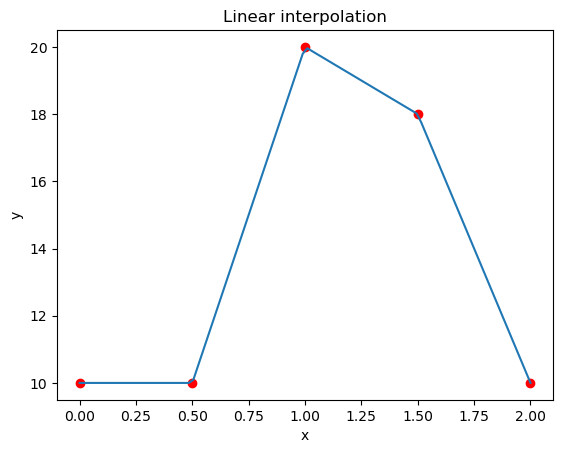

In [35]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax=plt.subplots()
xx=np.linspace(0,2,100)
ff=[f(x_i) for x_i in xx]
ax.set_title('Linear interpolation')
ax.plot(xx,ff)
ax.scatter(x,y,color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# Cubic spline interpolation

Here the interpolating functions are a set of __cubic polynomials__:
we assume that $(x_i,y_i)$ and $(x_{i+1},y_{i+1})$ are connected by $S_i=a_i x^3+b_i x^2 +c_i x+d_i$.

For $n$ points there are $n-1$ cubic polynomials, each with $4$ dofs, hence we have a total of $4(n-1)$ coefficients to find.

We have immediately $2(n-1)$ constraints from the fact that each $S_i$ must intersect $y_i \,\,(y_{i+1})$ at $x_i\,\, (x_{i+1})$:
<center>$S_i(x_i)=y_i,\qquad S_{i}(x_{i+1})=y_{i+1},\qquad\forall i=1\dots n-1$</center>

Then we also require smoothness of all $S_i$ at internal interpolation points, i.e. for $i=2,\dots,n-1$ (We don't need this at the two final points $x_1$ and $x_n$). This is done by requiring that first and second derivative of consecutive $S_i$ are continuos there:
<center> $S_i'(x_{i+1})=S_{i+1}'(x_{i+1}),\qquad S_i''(x_{i+1})=S_{i+1}''(x_{i+1}),\qquad\forall i=1,\dots,n-1$</center>
This give us further $2(n-2)$ constraints.

Two more equations are needed. Usually one requires that the curve is "straight at the endpoints", i.e.:
<center>$S''_1(x_1)=0,\qquad S''_{n-1}(x_n)=0$.</center>

We can use the `scipy.interpolate` function `CubicSpline`, which lets us set the last two boundary conditions via the keyword argument `bc_type`.

In [54]:
from scipy.interpolate import CubicSpline
x = [0, 1, 2]
y = [1, 3, 2]

# use bc_type = 'natural' adds the constraints as we described above
f=CubicSpline(x, y, bc_type='natural')

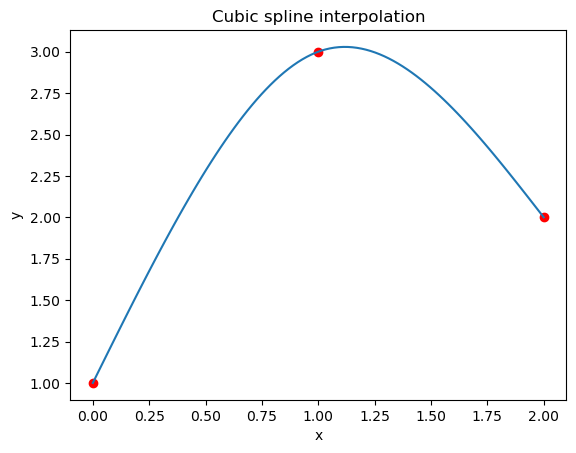

In [55]:
x_new = np.linspace(0, 2, 100)
y_new = f(x_new)
fig,ax=plt.subplots()
ax.set_title('Cubic spline interpolation')
ax.plot(x_new,y_new)
ax.scatter(x,y,color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

If you want explicit coefficients for the cubic spline, you should solve the corresponding linear system explicitly, apparently.

Example: let x=[0,1,2], y=[1,3,2]. We have only two basis functions $S_1$, $S_2$ and a total of 8 coefficients to fix.
The first set of equations relate $S_1$ with $y_1, y_2$ and $S_2$ with $y_2,y_3$:

$S_1(x_1)=y_1 \rightarrow d_1=1$

$S_1(x_2)=y_2 \rightarrow a_1+b_1+c_1+d_1=3$

$S_2(x_2)=y_2 \rightarrow a_2+b_2+c_2+d_2=3$

$S_2(x_3)=y_3 \rightarrow 8 a_2+ 4 b_2+2 c_2+d_2=2$

Then we have the equations imposing smoothness of $S_1$ and $S_2$ at the junction point $x_2$:

$S_1'(x_2)=S_2'(x_2) \rightarrow 3 a_1+ 2 b_1 + c_1 = 3 a_2 +2 b_2 +c_2$

$S_1''(x_2)=S_2''(x_2) \rightarrow 6 a_1+ 2 b_1 = 6 a_2 +2 b_2$

Finally the two flatness conditions at the boundaries $x_1,x_3$:

$S_1''(x_1)=0 \rightarrow 2 b_1 = 0$

$S_2''(x_3)=0 \rightarrow 12 a_2+2 b_2 = 0$

All in all, this becomes the linear system:

$\begin{pmatrix} 0&0&0&1&0&0&0&0\\
                 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0\\
                 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1\\
                 0 & 0 & 0 & 0 & 8 & 4 & 2 & 1\\
                 3 & 2 & 1 & 0 & -3 & -2 & -1 & 0\\
                 6 & 2 & 0 & 0 &-6 & -2 & 0 & 0\\
                 0 & 2 & 0 & 0 & 0 & 0 & 0 & 0\\
                 0 & 0 & 0 & 0 & 12 & 2 & 0 &0 \end{pmatrix} $
$\begin{pmatrix}a_1 \\ b_1 \\ c_1 \\d_1 \\a_2 \\ b_2 \\ c_2 \\ d_2 \end{pmatrix}$ = $\begin{pmatrix} 1 \\ 3 \\ 3 \\ 2 \\ 0 \\ 0\\ 0 \\ 0 \end{pmatrix}$

Apparently the matrix $M$ here is always invertible if the point $x_i$ are all unique.

In [46]:
M=np.array([[0,0,0,1,0,0,0,0],[1,1,1,1,0,0,0,0],[0,0,0,0,1,1,1,1],[0,0,0,0,8,4,2,1],[3,2,1,0,-3,-2,-1,0],[6,2,0,0,-6,-2,0,0],[0,2,0,0,0,0,0,0],[0,0,0,0,12,2,0,0]])
Mm1=np.linalg.inv(M)
const=np.array([[1,3,3,2,0,0,0,0]]).T
coeffs=np.dot(Mm1,const)
print(coeffs)

[[-0.75]
 [ 0.  ]
 [ 2.75]
 [ 1.  ]
 [ 0.75]
 [-4.5 ]
 [ 7.25]
 [-0.5 ]]


In [47]:
def S1(x):
    return -0.75*x**3+2.75*x+1
def S2(x):
    return 0.75*x**3-4.5*x**2+7.25*x-0.5

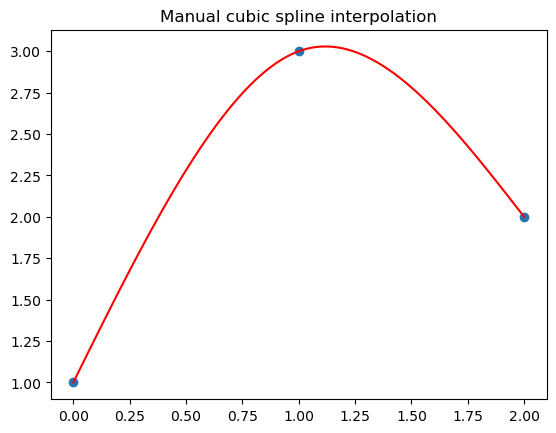

In [61]:
fig,ax=plt.subplots()
ax.set_title('Manual cubic spline interpolation')
x1_set = np.linspace(0, 1, 100)
x2_set = np.linspace(1, 2, 100)
SS1=[S1(x) for x in x1_set]
SS2=[S2(x) for x in x2_set]
ax.plot(x1_set, SS1, color='r')
ax.plot(x2_set, SS2, color = 'r')
ax.scatter([0,1,2],[1,3,2])
plt.show()

# Lagrange polynomial interpolation

Lagrange poly interpolation finds a polynomials that passes through all data points, which is called the __Lagrange polynomial__ $L(x)$, and it will be such that $L(x_i)=y_i,\,\,\forall i$. Of course it will have degree $n-1$, where $n$ is the number of data points.

The Lagrange poly will be a linear combination of __Lagrange basis polynomials__ $P_i(x)$, where:
<center>$P_i(x)=\prod_{j=1, j\neq i}^n \dfrac{x-x_j}{x_i-x_j}$ and $L(x)=\sum_{i=1}^n y_iP_i(x)$.</center>
Note that the basis polynomials have the properties $P_i(x_i)= \prod_j\frac{x_i-x_j}{x_i-x_j}=1, P_i(x_j)=0,\,\,\forall j\neq i$.

We can do this manually of course. Let's see an example. Our data points are $x=(0,1,2)$ and $y=(1,3,2)$. The basis polynomials are:
- $P_1=(x-1)(x-2)/2=\dfrac{x^2}{2}-\frac{3x}{2}+1$
- $P_2=-x(x-2)=-x^2+2x$
- $P_3=x(x-1)/2=\dfrac{x^2-x}{2}$

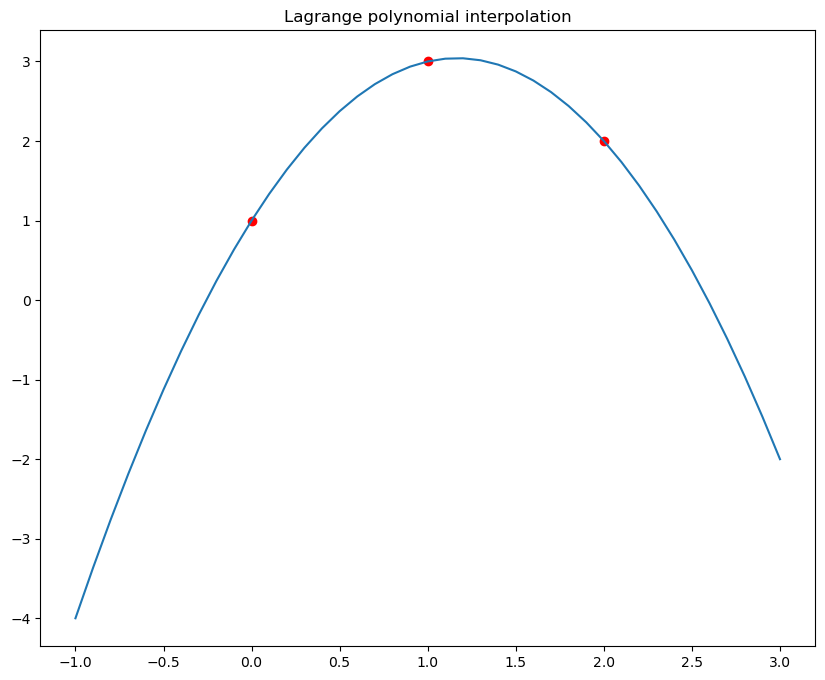

In [76]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
x = [0, 1, 2]
y = [1, 3, 2]
P1_coeff = [1,-1.5,.5]
P2_coeff = [0, 2,-1]
P3_coeff = [0,-.5,.5]

# get the polynomials
P1 = poly.Polynomial(P1_coeff)
P2 = poly.Polynomial(P2_coeff)
P3 = poly.Polynomial(P3_coeff)

x_new = np.arange(-1.0, 3.1, 0.1) #points to plot

L=P1+3*P2+2*P3 #Lagrange polynomial
fig = plt.figure(figsize = (10,8))
plt.plot(x_new,L(x_new))
plt.scatter(x,y,color='r')
plt.title('Lagrange polynomial interpolation')
plt.show()

N.B. Lagrange polynomials are defined in all R, however outside our data region they will go to $\pm \infty$: their asymptotics are generically very wrong.

## Using lagrange from scipy

The function `lagrange` from `scipy.interpolate` does Lagrange interpolation for us.

In [81]:
from scipy.interpolate import lagrange
x = [0, 1, 2]
y = [1, 3, 2]
f = lagrange(x, y)
print(f) #lagrange polynomial corresponding to our data

      2
-1.5 x + 3.5 x + 1


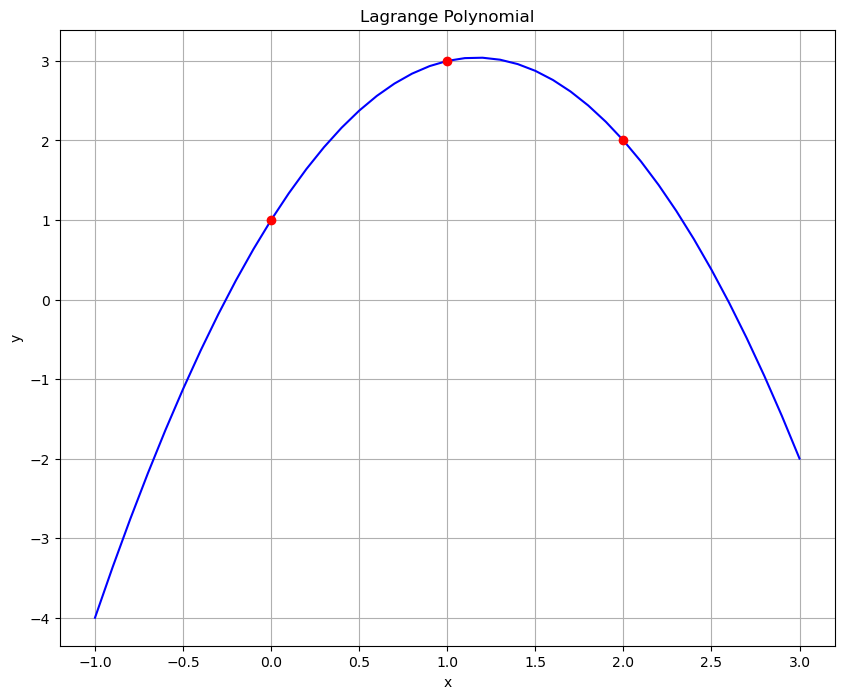

In [79]:
fig = plt.figure(figsize = (10,8))
plt.plot(x_new, f(x_new), 'b', x, y, 'ro')
plt.title('Lagrange Polynomial')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Newton polynomial interpolation

This interpolation fits $n$ data points with a polynomial of degree $n-1$ using the formula:
<center> $f(x)=\sum_{i=0}^n a_i n_i(x),\,\,\,n_i(x)=\prod_{j=0}^{i-1} (x-x_j)$</center>
The advantage is that coefficients $a_i$ can be determined quite simply via a recursive procedure.

Basically we see that:
- $f(x_0)=a_0=y_0$
- $f(x_1)= y_0 + a_1 (x_1-x_0) = y_1 \rightarrow a_1 = \dfrac{y_1 -y_0}{x_1-x_0}$
- $f(x_2)= y_0 + \dfrac{y_1 -y_0}{x_1-x_0} (x_2-x_0) + a_2 (x_2-x_0)(x_2-x_1) = y_2 \rightarrow a_2 =\dfrac{ \dfrac{y_2 - y_1}{x_2-x_1} - \dfrac{y_1 -y_0}{x_1-x_0} }{x_2-x_0}$

This can be more easily rewritten in terms of __divided differences__:
- $f[x_0,x_1]\equiv \dfrac{y_1-y_0}{x_1-x_0}$
- $f[x_0,x_1,x_2]\equiv \dfrac{ \dfrac{y_2 - y_1}{x_2-x_1} - \dfrac{y_1 -y_0}{x_1-x_0} }{x_2-x_0} = \dfrac{f[x_2,x_1]-f[x_1,x_0]}{x_2-x_0}$
- ...
- $f[x_0,\dots, x_k]\equiv \dfrac{f[x_1 \dots x_k]- f[x_0 \dots x_{k-1}]}{x_k-x_0}$

These coefficients are stored in the __incidence matrix__:
\begin{pmatrix} y_0 & f[x_1,x_0] & f[x_2,x_1,x_0]& \dots & f[x_{n-1},\dots, x_0]&f[x_n,\dots, x_0]\\
y_1 & f[x_2,x_1] & f[x_3,x_2,x_1]& \dots & f[x_{n},\dots, x_1]&0\\
& & &\dots \\
y_{n-1} & f[x_{n},x_{n-1}]& 0 & \dots & 0 & 0\\
y_n & 0 & 0 & \dots & 0 & 0
\end{pmatrix}
Note that the first row has all the coefficients needed.

We now write a function to compute these coefficients.

In [92]:
def divided_diffs(x,y):
    '''
    Retrieves incidence matrix given data points x,y
    '''
    n=len(y)
    coeff=np.zeros([n,n]) #initialize incidence matrix
    coeff[:,0]=y # first column is y
    for j in range(1,n):
        for i in range(n-j):
            coeff[i][j]=(coeff[i+1][j-1]-coeff[i][j-1])/(x[i+j]-x[i])
    return coeff
def newton_poly(coeff,x_data,x):
    n=len(x_data)-1 #degree of poly
    p=coeff[n]
    for k in range(1,n+1):
        p = coeff[n-k] + (x -x_data[n-k])*p
        # start from highest degree poly and add lower term each iteration, multiplying the old part by (x-x_i).
        #At the end the highest degree will be multiplied by all relevant factors.
    return p

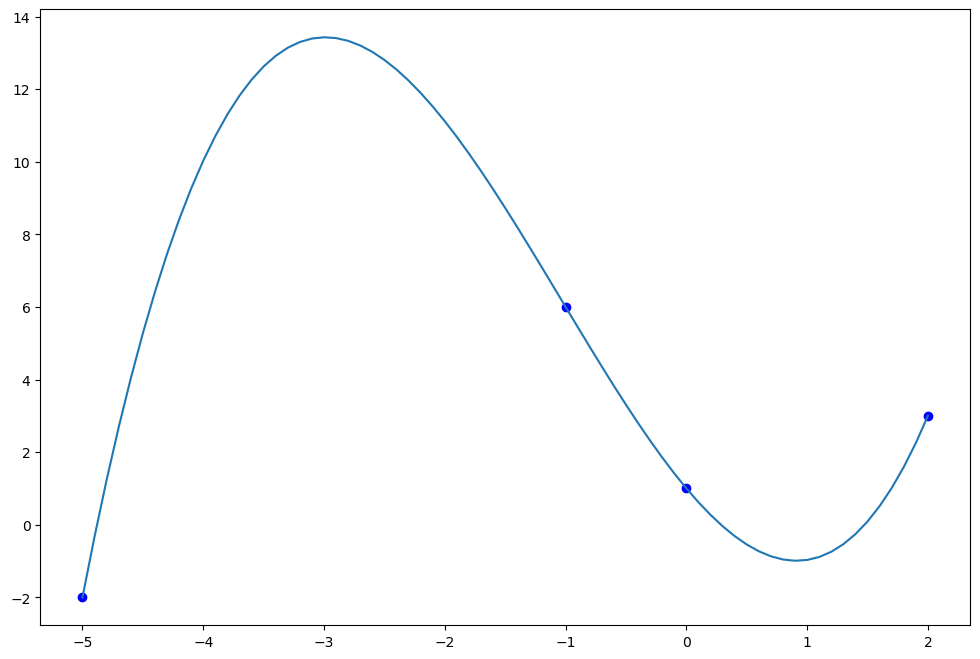

In [93]:
x = np.array([-5, -1, 0, 2])
y = np.array([-2, 6, 1, 3])
# get the divided difference coef
a_s = divided_diffs(x, y)[0, :]

# evaluate on new data points
x_new = np.arange(-5, 2.1, .1)
y_new = newton_poly(a_s, x, x_new)

plt.figure(figsize = (12, 8))
plt.plot(x, y, 'bo')
plt.plot(x_new, y_new)
plt.show()

# Problems

1) Write a function my_lin_interp(x, y, X), where x and y are arrays containing experimental data points, and X is an array. Assume that x and X are in ascending order and have unique elements. The output argument, Y, should be an array, the same size as X, where Y[i] is the linear interpolation of X[i].

In [377]:
#failed attempt
def my_lin_interp(x,y,X):
    n=len(x)
    (xx,yy)=X.shape
    mat=[]
    Y=np.zeros([xx,yy])
    for i in range(n-1):
        #f[i](x) should be straight line interpolating between (x[i],y[i]) and (x[i+1],y[i+1])
        mat.append(lambda gg:y[i]+(y[i+1]-y[i])*(gg-x[i])/(x[i+1]-x[i]))
    for row in range(len(X)):
        for el in range(len(X[row])):
            j=0
            while j<n-1 and X[row,el]<x[j]:
                j+=1
            Y[row,el]=mat[i](X[row,el])
    return Y, mat
#Problem: f is sort of defined globally so mat is a vector containing the same function (the last one) over and over.

In [406]:
def my_lin_interp(x, y, X):
    Y = np.zeros(X.shape)
    for i in range(X.shape[0]):
        j = 0
        for k in range(X.shape[1]):
            while j<len(x)-2 and X[i, k] > x[j+1]:  # Find the interval X[i, k] belongs to
                j += 1
            # Perform linear interpolation
            Y[i, k] = y[j] + (X[i, k] - x[j]) * (y[j+1] - y[j]) / (x[j+1] - x[j])
    return Y

In [418]:
import numpy as np

# Define the experimental data points
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 30, 5, 20, 11])

# Define the points where we want to interpolate
X = np.array([np.linspace(1,5,10), np.linspace(5,10,10)])

# Call the function
Y = my_lin_interp(x, y, X)

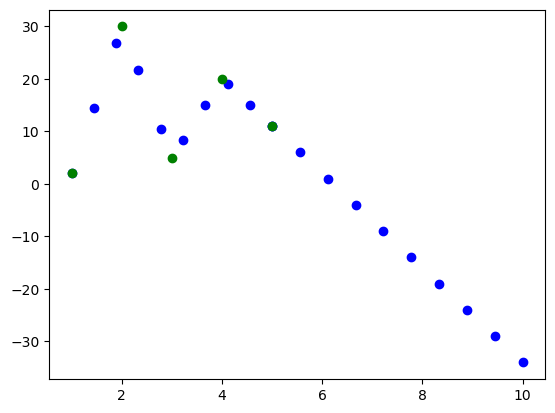

In [421]:
plt.scatter(X,Y,c='b')
plt.scatter([1, 2, 3, 4, 5],[2, 30, 5, 20, 11],c='g')
plt.show()

2) check out `interp1d` from `scipy`

Syntax:
`scipy.interpolate.interp1d(x,y,kind,axis)`
- x is $1\times D$ array of data
- y is a $N\times D$ array of data. Its length along `axis` option must be the same length as x.
- `kind` takes values `linear`, `nearest`, `nearest-up`, `zero`, `slinear`, `quadratic`, `cubic`, `previous`, or `next`. ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of zeroth, first, second or third order; ‘previous’ and ‘next’ simply return the previous or next value of the point; ‘nearest-up’ and ‘nearest’ differ when interpolating half-integers (e.g. 0.5, 1.5) in that ‘nearest-up’ rounds up and ‘nearest’ rounds down. Default is ‘linear’.

  N.B. This is a legacy function!

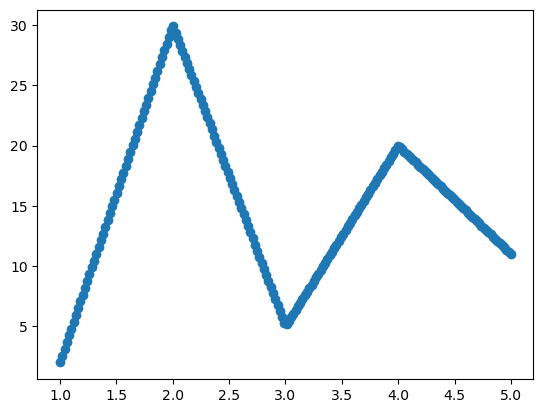

In [442]:
from scipy.interpolate import interp1d
linear_interp=interp1d(np.array([1, 2, 3, 4, 5]),np.array([2, 30, 5, 20, 11]), kind='linear')
X = np.linspace(1,5,200)
plt.scatter(X,linear_interp(X))
plt.show()

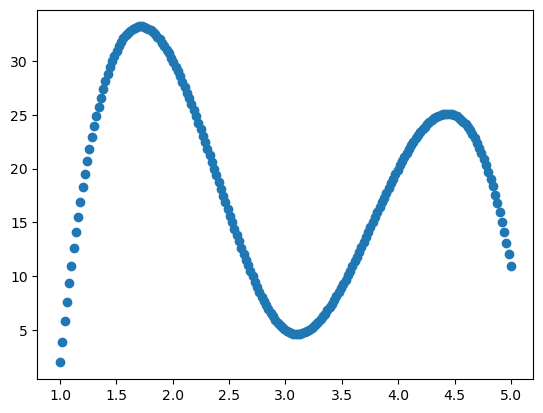

In [443]:
from scipy.interpolate import interp1d
linear_interp=interp1d(np.array([1, 2, 3, 4, 5]),np.array([2, 30, 5, 20, 11]), kind='cubic')
X = np.linspace(1,5,200)
plt.scatter(X,linear_interp(X))
plt.show()

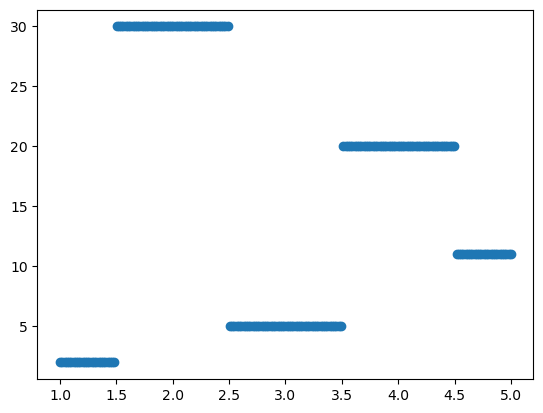

In [448]:
from scipy.interpolate import interp1d
linear_interp=interp1d(np.array([1, 2, 3, 4, 5]),np.array([2, 30, 5, 20, 11]), kind='nearest-up')
X = np.linspace(1,5,200)
plt.scatter(X,linear_interp(X))
plt.show()